In [1]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
import warnings
import importlib
import os
import scipy
import tqdm

warnings.filterwarnings("ignore")
import fit_pkpd

importlib.reload(fit_pkpd)

<module 'fit_pkpd' from '/Users/harshparikh/Documents/GitHub/iic_causal_inference/aim2/fit_pkpd.py'>

In [2]:
os.cpu_count()

16

### path to Sahar's data

In [3]:
data_folder_path = "/Users/harshparikh/Documents/RCT_sim_code/"
cnn_labels = "CNN_Label/"
drug = "Combined_Drug_Normalize/"
# patients = list(map(lambda x: x.replace('.mat',''), os.listdir( data_folder_path+drug )))
patients = [
    "sid1158",
    "sid871",
    "sid708",
    "sid287",
    "sid1832",
    "sid286",
    "sid1211",
    "sid1577",
    "sid877",
    "sid320",
    "sid861",
    "sid350",
    "sid967",
    "sid1112",
    "sid351",
    "sid345",
    "sid353",
    "sid804",
    "sid958",
    "sid970",
    "sid742",
    "sid959",
    "sid949",
    "sid341",
    "sid962",
    "sid1117",
    "sid1881",
    "sid826",
    "sid1127",
    "sid1118",
    "sid1125",
    "sid1119",
    "sid1535",
    "sid834",
    "sid1486",
    "sid1109",
    "sid1532",
    "sid716",
    "sid1144",
    "sid850",
    "sid846",
    "sid1194",
    "sid922",
    "sid854",
    "sid868",
    "sid920",
    "sid855",
    "sid699",
]

In [4]:
t_half = {
    "levetiracetam": 48,
    "lacosamide": 66,
    "midazolam": 15,
    "phenobarbital": 474,
    "pentobarbital": 195,
    "propofol": 2,
    "valproate": 96,
}

### path to git iic data


In [5]:
path_to_git = "/Users/harshparikh/Documents/GitHub/iic_causal_inference/"

iic_burden = pd.read_pickle(
    path_to_git + "aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle"
)

iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'sids', 'pseudoMRNs'])

### getting Sahar's cohort from IIC

In [6]:
idxs = pd.DataFrame(iic_burden["sids"])
idxs = idxs.reset_index()
patients_idx = idxs.set_index(0).loc[patients].values.T[0]
patients_idx

array([ 796,  588,  488,  183, 1215,  182,  824, 1052,  593,  208,  582,
        231,  663,  759,  232,  228,  234,  541,  658,  665,  514,  659,
        650,  225,  660,  764, 1247,  555,  774,  765,  772,  766, 1028,
        560,  997,  756, 1026,  492,  786,  573,  570,  814,  626,  577,
        586,  624,  578,  482])

# PD Model Fitting

In [7]:
import fit_pkpd

importlib.reload(fit_pkpd)

<module 'fit_pkpd' from '/Users/harshparikh/Documents/GitHub/iic_causal_inference/aim2/fit_pkpd.py'>

In [20]:
columns = []
drugs_interest = ["levetiracetam", "propofol"]
for drug in drugs_interest:
    for i in ["50", "B", "Hill"]:
        columns += [drug + "_" + str(i)]
columns = columns + [
    "baseline_avg",
    "baseline_heavytail_mu",
    "baseline_heavytail_sigma",
]

In [21]:
df_data_summary = []
for i in tqdm.tqdm(patients_idx):
    D = iic_burden["D"][i]
    l = list(pd.DataFrame(D, columns=iic_burden["Dname"]).sum())
    E = pd.Series(iic_burden["Pobs"][i])
    l += [np.sum(E)]
    df_data_summary += [l]
df_data_summary = pd.DataFrame(
    df_data_summary, columns=iic_burden["Dname"] + ["EA"], index=patients_idx
)

100%|██████████| 48/48 [00:00<00:00, 1252.19it/s]


In [22]:
(df_data_summary > 0).sum()

lacosamide        1
levetiracetam    33
midazolam         0
pentobarbital     0
phenobarbital     1
propofol         38
valproate         0
lorazepam         2
diazepam          0
fosphenytoin      0
EA               47
dtype: int64

In [23]:
pd_param_df = pd.DataFrame()
for i in tqdm.tqdm(patients_idx):
    D = iic_burden["D"][i]
    D = pd.DataFrame(D, columns=iic_burden["Dname"])[drugs_interest]
    E = pd.Series(iic_burden["Pobs"][i])
    E = E.interpolate(method="linear")
    pd_params = pd.DataFrame(
        np.array([fit_pkpd.fit_PD(E, D)]),
        index=[iic_burden["sids"][i]],
        columns=columns,
    )
    pd_param_df = pd_param_df.append(pd_params)
pd_param_df = pd_param_df

100%|██████████| 48/48 [05:15<00:00,  6.58s/it]


In [24]:
pd_param_df.to_csv("pd_params_lev_prop_sahardata.csv")

Text(0.5, 0, 'Time Steps (1 Step = 10 min)')

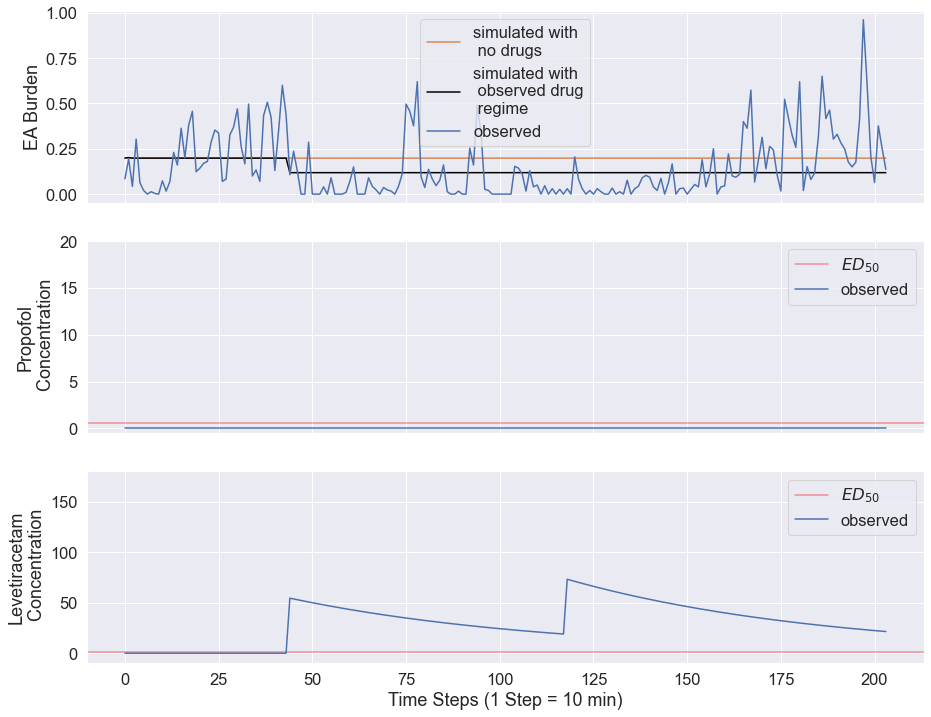

In [12]:
sns.set(font_scale=1.5)
j = 0

i = patients_idx[j]
D = iic_burden["D"][i]
D = pd.DataFrame(D, columns=iic_burden["Dname"])[drugs_interest]
E = pd.Series(iic_burden["Pobs"][i])
E = E.interpolate(method="linear")

E_sim = fit_pkpd.sim_patient(
    pd_params=pd_param_df.iloc[j].values,
    D_=D.values,
    Timesteps=iic_burden["D"][i].shape[0],
)
E_sim0 = fit_pkpd.sim_patient(
    pd_params=pd_param_df.iloc[j].values,
    D_=np.zeros_like(D.values),
    Timesteps=iic_burden["D"][i].shape[0],
)

fig, ax = plt.subplots(nrows=3, figsize=(15, 12), sharex=True)


ax[0].plot(E_sim0, c="C1")
ax[0].plot(E_sim, c="black")
ax[0].plot(E)
ax[0].legend(
    ["simulated with\n no drugs", "simulated with\n observed drug\n regime", "observed"]
)
ax[0].set_ylabel("EA Burden")

ax[1].axhline(pd_param_df["propofol_50"].iloc[j], c="red", alpha=0.4)
ax[1].plot(D["propofol"])
ax[1].legend([r"$ED_{50}$", "observed"])
ax[1].set_ylabel("Propofol\n Concentration")
ax[1].set_ylim((-0.5, 20))

ax[2].axhline(pd_param_df["levetiracetam_50"].iloc[j], c="red", alpha=0.4)
ax[2].plot(D["levetiracetam"])
ax[2].set_ylabel("Levetiracetam\n Concentration")
ax[2].set_ylim((-10, 180))
ax[2].legend([r"$ED_{50}$", "observed"])
ax[2].set_xlabel("Time Steps (1 Step = 10 min)")

# plt.savefig('/Users/harshparikh/Documents/RCT_sim_code/HillPD_Figures/'+patients[j]+'_Hill_PD_w_lognormal_baseline.png')

In [ ]:
for j in range(len(patients_idx)):
    sns.set(font_scale=1.5)

    i = patients_idx[j]
    D = iic_burden['D'][i]
    D = pd.DataFrame(D,columns=iic_burden['Dname'])[drugs_interest]
    E = pd.Series(iic_burden['Pobs'][i])
    E = E.interpolate(method='linear')

    E_sim = fit_pkpd.sim_patient(pd_params=pd_param_df.iloc[j].values,
                         D_=D.values,
                         Timesteps=iic_burden['D'][i].shape[0])
    E_sim0 = fit_pkpd.sim_patient(pd_params=pd_param_df.iloc[j].values,
                         D_=np.zeros_like(D.values),
                         Timesteps=iic_burden['D'][i].shape[0])

    fig,ax = plt.subplots(nrows=3,figsize=(15,12),sharex=True)


    ax[0].plot(E_sim0,c='C1')
    ax[0].plot(E_sim,c='black')
    ax[0].plot(E)
    ax[0].legend(['simulated with\n no drugs','simulated with\n observed drug\n regime','observed'])
    ax[0].set_ylabel('EA Burden')
    ax[0].set_title(patients[j])

    ax[1].axhline(pd_param_df['propofol_50'].iloc[j],c='red',alpha=0.4)
    ax[1].plot(D['propofol'])
    ax[1].legend([r'$ED_{50}$','observed'])
    ax[1].set_ylabel('Propofol\n Concentration')
    ax[1].set_ylim((-0.5,20))

    ax[2].axhline(pd_param_df['levetiracetam_50'].iloc[j],c='red',alpha=0.4)
    ax[2].plot(D['levetiracetam'])
    ax[2].set_ylabel('Levetiracetam\n Concentration')
    ax[2].set_ylim((-10,180))
    ax[2].legend([r'$ED_{50}$','observed'])
    ax[2].set_xlabel('Time Steps (1 Step = 10 min)')

    plt.savefig('/Users/harshparikh/Documents/RCT_sim_code/HillPD_Figures/'+patients[j]+'_Hill_PD_w_lognormal_baseline.png')

In [ ]:
pd_param_df.round(4).head()

# Outcome Regression

In [18]:
def setup_coarsen_data(
    iic_burden, drugs_interest, window=36, summarize="max", **kwargs
):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in range(n):
        t = len(iic_burden["Pobs"][i])
        if t > window:
            if summarize == "max":
                E = np.max(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "proportion":
                threshold = kwargs.get("threshold", 0.5)
                E = np.nanmean(
                    np.array(
                        [
                            np.nanmean(iic_burden["Pobs"][i][j : j + window])
                            for j in range(t - window)
                        ]
                    )
                    > threshold
                )
            if summarize == "mean":
                E = np.mean(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
        else:
            E = np.nanmean(iic_burden["Pobs"][i])
        E_col.append(E)
        D = np.nanmean(iic_burden["D"][i], axis=0)
        D_col.append(D)
    df["E"] = E_col
    df_D = pd.DataFrame(D_col, columns=iic_burden["Dname"], index=df.index)
    df = df.join(df_D[drugs_interest], how="inner")
    return df


import sklearn.ensemble as en

df_coarse_max = setup_coarsen_data(
    iic_burden, drugs_interest=drugs_interest, window=36, summarize="max"
).dropna()

In [19]:
df_coarse_max.head()

,Gender,Age,Marrital,iGCS-Total,iGCS = T?,Worst GCS in 1st 24h,Worst GCS intub,APACHE II 1st 24h,SBP highest (1st 24h),SBP lowest (1st 24h),...,PrimDx:NonHeadTrauma,PrimDx:Malignancy,PrimDx:Hem,Race_Asian,Race_Black or African American,Race_Other,mRS,E,levetiracetam,propofol
sid2,0.0,85.01,0.0,7.0,0.0,3.0,1.0,27.0,183.0,111.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.930249,43.125745,0.000000
sid3,1.0,45.91,1.0,8.0,0.0,8.0,0.0,15.0,148.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.912167,62.054354,0.000000
sid4,1.0,53.99,1.0,4.0,0.0,3.0,1.0,29.0,170.0,50.0,...,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.847480,25.875147,12.181081
sid5,1.0,23.08,0.0,6.0,1.0,3.0,1.0,22.0,126.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.030686,0.000000,8.922900
sid6,1.0,25.66,0.0,14.0,0.0,12.0,0.0,3.0,144.0,104.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.768224,0.000000,0.000000


In [20]:
m_y = en.GradientBoostingClassifier().fit(
    X=df_coarse_max.drop(columns=["mRS"]), y=(df_coarse_max["mRS"] > 4).astype(int)
)

# Power Analysis

In [21]:
def sim(
    pd_params, halflife, delay=0, dose=1, drug="levetiracetam", interval=48, length=576
):
    idx_drug = drugs_interest.index(drug)
    D_ = np.zeros((length, len(drugs_interest)))
    for timepoint in range(delay, length, interval):
        D_[timepoint, idx_drug] = dose  # *pd_params[drugs_interest[idx_drug]+'_50']
    D_ = fit_pkpd.PK(D_, halflife)
    E_sim = fit_pkpd.sim_patient(pd_params=pd_params.values, D_=D_, Timesteps=length)
    return E_sim, D_


def plot(E, D, Y, drugs_interest, ax, i=1):
    ax[0].plot(E)
    ax[0].set_ylabel("Sim. EA Burden")
    ax[3].bar(x=i, height=Y, width=0.5, alpha=0.5)

    for i in range(D.shape[1]):
        ax[i + 1].plot(D[:, i])
        ax[i + 1].set_ylabel("%s\n Concentration" % (drugs_interest[i]))


def summary(E, D, window=36, summarize="max"):
    t = len(E)
    if t > window:
        if summarize == "max":
            Esum = np.max([np.nanmean(E[j : j + window]) for j in range(t - window)])
        if summarize == "proportion":
            threshold = kwargs.get("threshold", 0.5)
            Esum = np.nanmean(
                np.array([np.nanmean(E[j : j + window]) for j in range(t - window)])
                > threshold
            )
        if summarize == "mean":
            Esum = np.mean([np.nanmean(E[j : j + window]) for j in range(t - window)])
    else:
        Esum = np.nanmean(E)
    Dsum = np.nanmean(D, axis=0)
    return Esum, Dsum


def outcome(Esum, Dsum, C, model_y, drugs_interest):
    X = C
    X["E"] = Esum
    for i in range(len(drugs_interest)):
        drug = drugs_interest[i]
        X[drug] = Dsum[i]
    y = model_y.predict_proba(X.values.reshape(1, -1))[:, 1]
    return y

In [22]:
def power(Y1, Y2, alpha=0.05):
    import scipy.stats as stats

    mu1 = np.mean(Y1)
    mu2 = np.mean(Y2)
    sigmasq1 = np.var(Y1)
    sigmasq2 = np.var(Y2)
    n1 = len(Y1)
    n2 = len(Y2)
    std1 = np.sqrt(sigmasq1 / n1)
    std2 = np.sqrt(sigmasq2 / n2)
    level = stats.norm.ppf(1 - alpha, loc=mu1, scale=std1)
    type2 = stats.norm.cdf(level, loc=mu2, scale=std2)
    power = 1 - type2
    return power

# Study: Effect of treatment A vs Placebo administered at different delay (same drug)
Treat this as k different RCTs each with 2 arms

In [23]:
pd_param_df = pd.read_csv("pd_params_lev_prop_sahardata.csv", index_col=0)
pd_param_df.mean()

levetiracetam_50            2.342253
levetiracetam_B             0.491623
levetiracetam_Hill          1.178237
propofol_50                 3.090730
propofol_B                  0.520665
propofol_Hill               4.899960
baseline_avg                0.751093
baseline_heavytail_mu       2.817057
baseline_heavytail_sigma    0.984208
dtype: float64

In [14]:
halflife = np.array([t_half[k] for k in drugs_interest])
N = pd_param_df.shape[0]
sample_size = 20
batch = 200
power_df = pd.DataFrame()
for seed in range(0,1):
    np.random.seed(seed)
    df_Y = pd.DataFrame()
    for j in tqdm.tqdm(range(sample_size)):
        idxarray = np.random.randint(N,size=batch) # sampling a random unit
        df_Y_ = pd.DataFrame() # local dataframe to store results 
        df_Y_['sid'] = [pd_param_df.index[i] for i in idxarray]

        # simulating unit under no delay
        Y1, Y2, Y3, Y4, Y5, Y6, Y7 = [],[],[],[],[],[],[]
        E1a, E2a, E3a, E4a, E5a, E6a, E7a = [],[],[],[],[],[],[]
        Esum1a, Esum2a, Esum3a, Esum4a, Esum5a, Esum6a, Esum7a = [],[],[],[],[],[],[]
        for i in idxarray:
            # simulating unit under 0hrs delay
            E2,D2 = sim(pd_param_df.iloc[i],halflife=halflife,dose=15)
            Esum2,Dsum2 = summary(E2,D2)
            C1 = df_coarse_max.drop(columns=['mRS','E']+drugs_interest).iloc[i]
            Y2 += list(outcome(Esum2,Dsum2,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum2a += [Esum2]
            E2a += [np.sum(E2)]

            # simulating unit under 12hrs delay
            E3,D3 = sim(pd_param_df.iloc[i],halflife=halflife,dose=15,delay=72)
            Esum3,Dsum3 = summary(E3,D3)
            Y3 += list(outcome(Esum3,Dsum3,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum3a += [Esum3]
            E3a += [np.sum(E3)]

             # simulating unit under 24hrs delay
            E4,D4 = sim(pd_param_df.iloc[i],halflife=halflife,dose=15,delay=144)
            Esum4,Dsum4 = summary(E4,D4)
            Y4 += list(outcome(Esum4,Dsum4,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum4a += [Esum4]
            E4a += [np.sum(E4)]
            
            # simulating unit under 0hrs delay
            E5,D5 = sim(pd_param_df.iloc[i],halflife=halflife,dose=7)
            Esum5,Dsum5 = summary(E5,D5)
            Y5 += list(outcome(Esum5,Dsum5,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum5a += [Esum5]
            E5a += [np.sum(E5)]

            # simulating unit under 12hrs delay
            E6,D6 = sim(pd_param_df.iloc[i],halflife=halflife,dose=7,delay=72)
            Esum6,Dsum6 = summary(E6,D6)
            Y6 += list(outcome(Esum6,Dsum6,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum6a += [Esum6]
            E6a += [np.sum(E6)]

             # simulating unit under 24hrs delay
            E7,D7 = sim(pd_param_df.iloc[i],halflife=halflife,dose=7,delay=144)
            Esum7,Dsum7 = summary(E7,D7)
            Y7 += list(outcome(Esum7,Dsum7,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum7a += [Esum7]
            E7a += [np.sum(E7)]

            # simulating unit under no drugs (Placebo/Infinite Delay)
            E1,D1 = sim(pd_param_df.iloc[i],halflife=halflife,dose=0)
            Esum1,Dsum1 = summary(E1,D1)
            Y1 += list(outcome(Esum1,Dsum1,C1,model_y=m_y,drugs_interest=drugs_interest))
            Esum1a += [Esum1]
            E1a += [np.sum(E1)]


        df_Y_['Y(1,no delay)'] = Y2
        df_Y_[r'$E_{max}$(1,no delay)'] = Esum2a
        df_Y_[r'$E_{total}$(1,no delay)'] = E2a
        
        df_Y_['Y(1,12hrs delay)'] = Y3
        df_Y_[r'$E_{max}$(1,12hrs delay)'] = Esum3a
        df_Y_[r'$E_{total}$(1,12hrs delay)'] = E3a
        
        df_Y_['Y(1,24hrs delay)'] = Y4
        df_Y_[r'$E_{max}$(1,24hrs delay)'] = Esum4a
        df_Y_[r'$E_{total}$(1,24hrs delay)'] = E4a
        
        df_Y_['Y(0.5,no delay)'] = Y5
        df_Y_[r'$E_{max}$(0.5,no delay)'] = Esum5a
        df_Y_[r'$E_{total}$(0.5,no delay)'] = E5a
        
        df_Y_['Y(0.5,12hrs delay)'] = Y6
        df_Y_[r'$E_{max}$(0.5,12hrs delay)'] = Esum6a
        df_Y_[r'$E_{total}$(0.5,12hrs delay)'] = E6a
        
        df_Y_['Y(0.5,24hrs delay)'] = Y7
        df_Y_[r'$E_{max}$(0.5,24hrs delay)'] = Esum7a
        df_Y_[r'$E_{total}$(0.5,24hrs delay)'] = E7a
        
        df_Y_['Y(0)'] = Y1
        df_Y_[r'$E_{max}$(0)'] = Esum1a
        df_Y_[r'$E_{total}$(0)'] = np.sum(E1)




        df_Y_ = df_Y_.set_index('sid')

        df_Y = df_Y.append(df_Y_)

        power_ = pd.DataFrame([[ power(df_Y['Y(1,no delay)'],df_Y['Y(0)']), 
                                power(df_Y['Y(1,12hrs delay)'],df_Y['Y(0)']), 
                                power(df_Y['Y(1,24hrs delay)'],df_Y['Y(0)']),
                                power(df_Y['Y(1,no delay)'],df_Y['Y(0.5,no delay)']),
                                power(df_Y['Y(1,12hrs delay)'],df_Y['Y(0.5,12hrs delay)']),
                                power(df_Y['Y(1,24hrs delay)'],df_Y['Y(0.5,24hrs delay)']),
                                
                                power(df_Y[r'$E_{max}$(1,no delay)'],df_Y[r'$E_{max}$(0)']), 
                                power(df_Y[r'$E_{max}$(1,12hrs delay)'],df_Y[r'$E_{max}$(0)']), 
                                power(df_Y[r'$E_{max}$(1,24hrs delay)'],df_Y[r'$E_{max}$(0)']),
                                power(df_Y[r'$E_{max}$(1,no delay)'],df_Y[r'$E_{max}$(0.5,no delay)']),
                                power(df_Y[r'$E_{max}$(1,12hrs delay)'],df_Y[r'$E_{max}$(0.5,12hrs delay)']),
                                power(df_Y[r'$E_{max}$(1,24hrs delay)'],df_Y[r'$E_{max}$(0.5,24hrs delay)']),
                                
                                power(df_Y[r'$E_{total}$(1,no delay)'],df_Y[r'$E_{total}$(0)']), 
                                power(df_Y[r'$E_{total}$(1,12hrs delay)'],df_Y[r'$E_{total}$(0)']), 
                                power(df_Y[r'$E_{total}$(1,24hrs delay)'],df_Y[r'$E_{total}$(0)']),
                                power(df_Y[r'$E_{total}$(1,no delay)'],df_Y[r'$E_{total}$(0.5,no delay)']),
                                power(df_Y[r'$E_{total}$(1,12hrs delay)'],df_Y[r'$E_{total}$(0.5,12hrs delay)']),
                                power(df_Y[r'$E_{total}$(1,24hrs delay)'],df_Y[r'$E_{total}$(0.5,24hrs delay)'])
                               ]],
                              index=[batch*(j+1)],
                              columns=['Full Dose No Delay/Placebo',
                                       'Full Dose 12hrs Delay/Placebo',
                                       'Full Dose 18hrs Delay/Placebo',
                                       'Full Dose No Delay/Half Dose No Delay',
                                       'Full Dose 12hrs Delay/Half Dose 12hrs Delay',
                                       'Full Dose 18hrs Delay/Half Dose 24hrs Delay',
                                       
                                       r'$E_{max}$ Full Dose No Delay/Placebo',
                                       r'$E_{max}$ Full Dose 12hrs Delay/Placebo',
                                       r'$E_{max}$ Full Dose 18hrs Delay/Placebo',
                                       r'$E_{max}$ Full Dose No Delay/Half Dose No Delay',
                                       r'$E_{max}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay',
                                       r'$E_{max}$ Full Dose 18hrs Delay/Half Dose 24hrs Delay',
                                        
                                       r'$E_{total}$ Full Dose No Delay/Placebo',
                                       r'$E_{total}$ Full Dose 12hrs Delay/Placebo',
                                       r'$E_{total}$ Full Dose 18hrs Delay/Placebo',
                                       r'$E_{total}$ Full Dose No Delay/Half Dose No Delay',
                                       r'$E_{total}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay',
                                       r'$E_{total}$ Full Dose 18hrs Delay/Half Dose 24hrs Delay'])
        power_df = power_df.append(power_)

100%|██████████| 20/20 [24:12:33<00:00, 4357.66s/it]    


In [15]:
power_df.to_csv('/Users/harshparikh/Documents/RCT_sim_code/Power/'+'power_df_2.csv')

In [16]:
df_Y.to_csv('/Users/harshparikh/Documents/RCT_sim_code/Power/'+'power_df_y_2.csv')

# Plotting Result

In [41]:
power_df = pd.read_csv(
    "/Users/harshparikh/Documents/RCT_sim_code/Power/" + "power_df_2.csv", index_col=0
)
df_Y = pd.read_csv(
    "/Users/harshparikh/Documents/RCT_sim_code/Power/" + "power_df_y_2.csv", index_col=0
)

In [42]:
power_df.columns

Index(['Full Dose No Delay/Placebo', 'Full Dose 12hrs Delay/Placebo',
       'Full Dose 24hrs Delay/Placebo',
       'Full Dose No Delay/Half Dose No Delay',
       'Full Dose 12hrs Delay/Half Dose 12hrs Delay',
       'Full Dose 24hrs Delay/Half Dose 24hrs Delay',
       '$E_{max}$ Full Dose No Delay/Placebo',
       '$E_{max}$ Full Dose 12hrs Delay/Placebo',
       '$E_{max}$ Full Dose 24hrs Delay/Placebo',
       '$E_{max}$ Full Dose No Delay/Half Dose No Delay',
       '$E_{max}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay',
       '$E_{max}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay',
       '$E_{total}$ Full Dose No Delay/Placebo',
       '$E_{total}$ Full Dose 12hrs Delay/Placebo',
       '$E_{total}$ Full Dose 24hrs Delay/Placebo',
       '$E_{total}$ Full Dose No Delay/Half Dose No Delay',
       '$E_{total}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay',
       '$E_{total}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay'],
      dtype='object')

In [43]:
power_df = power_df.rename(
    columns={
        "Full Dose 18hrs Delay/Placebo": "Full Dose 24hrs Delay/Placebo",
        "Full Dose 18hrs Delay/Half Dose 24hrs Delay": "Full Dose 24hrs Delay/Half Dose 24hrs Delay",
        "$E_{max}$ Full Dose 18hrs Delay/Placebo": "$E_{max}$ Full Dose 24hrs Delay/Placebo",
        "$E_{max}$ Full Dose 18hrs Delay/Half Dose 24hrs Delay": "$E_{max}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay",
        "$E_{total}$ Full Dose 18hrs Delay/Placebo": "$E_{total}$ Full Dose 24hrs Delay/Placebo",
        "$E_{total}$ Full Dose 18hrs Delay/Half Dose 24hrs Delay": "$E_{total}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay",
    }
)

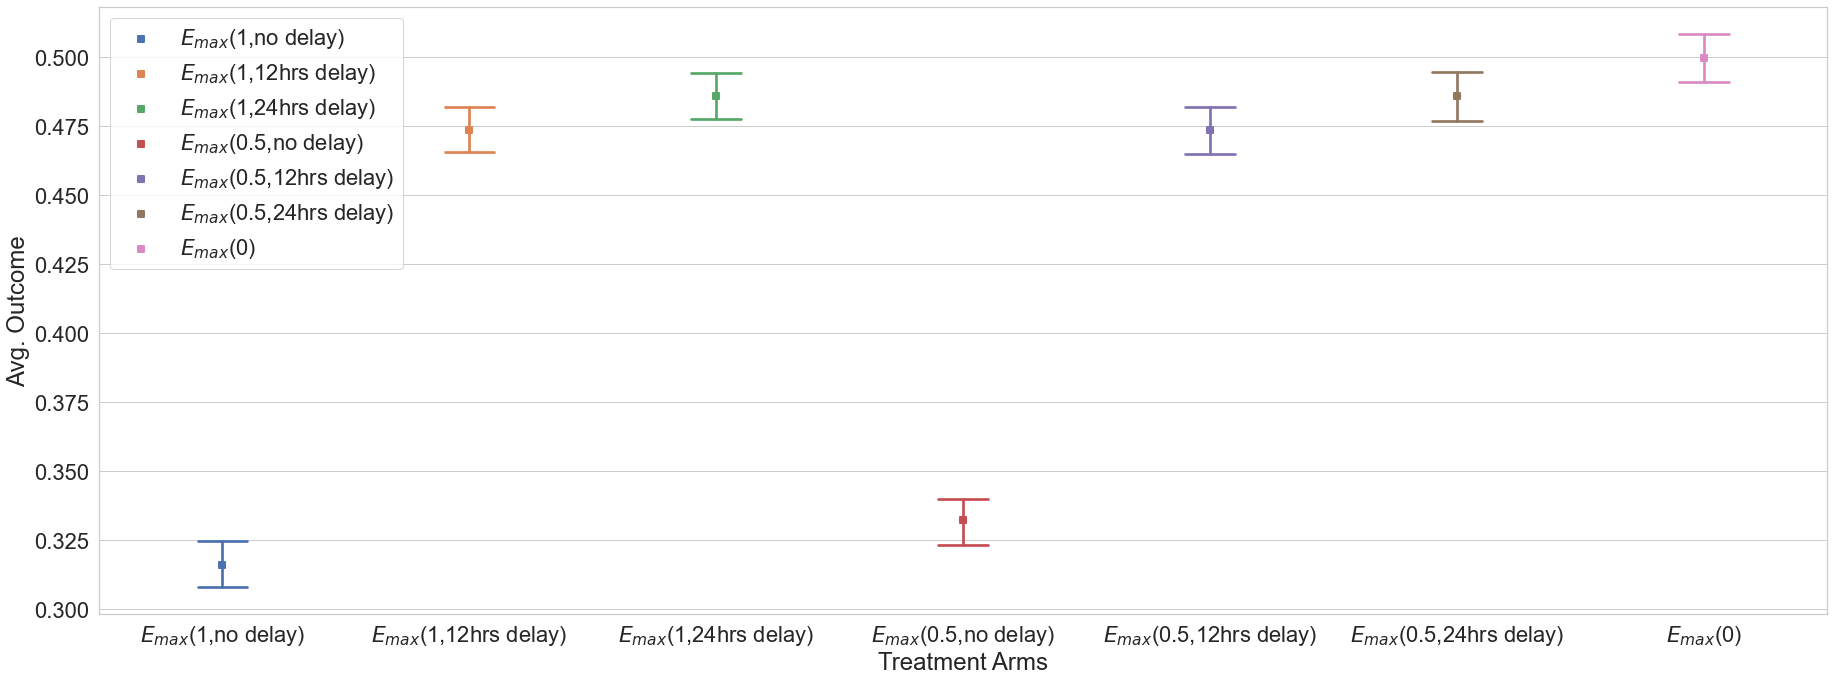

In [44]:
sns.set(style="whitegrid", font_scale=2)
Ys = [col for col in df_Y.columns if "Y" in col]
Emaxs = [col for col in df_Y.columns if r"$E_{max}$" in col]
Etotals = [col for col in df_Y.columns if r"$E_{total}$" in col]
fig, ax = plt.subplots(figsize=(26, 10))
sns.pointplot(
    data=df_Y[Emaxs].stack().reset_index(),
    x="level_1",
    y=0,
    ax=ax,
    join=False,
    capsize=0.2,
    markers="s",
    hue="level_1",
)
plt.legend()
plt.xlabel("Treatment Arms")
plt.ylabel("Avg. Outcome")
plt.tight_layout()

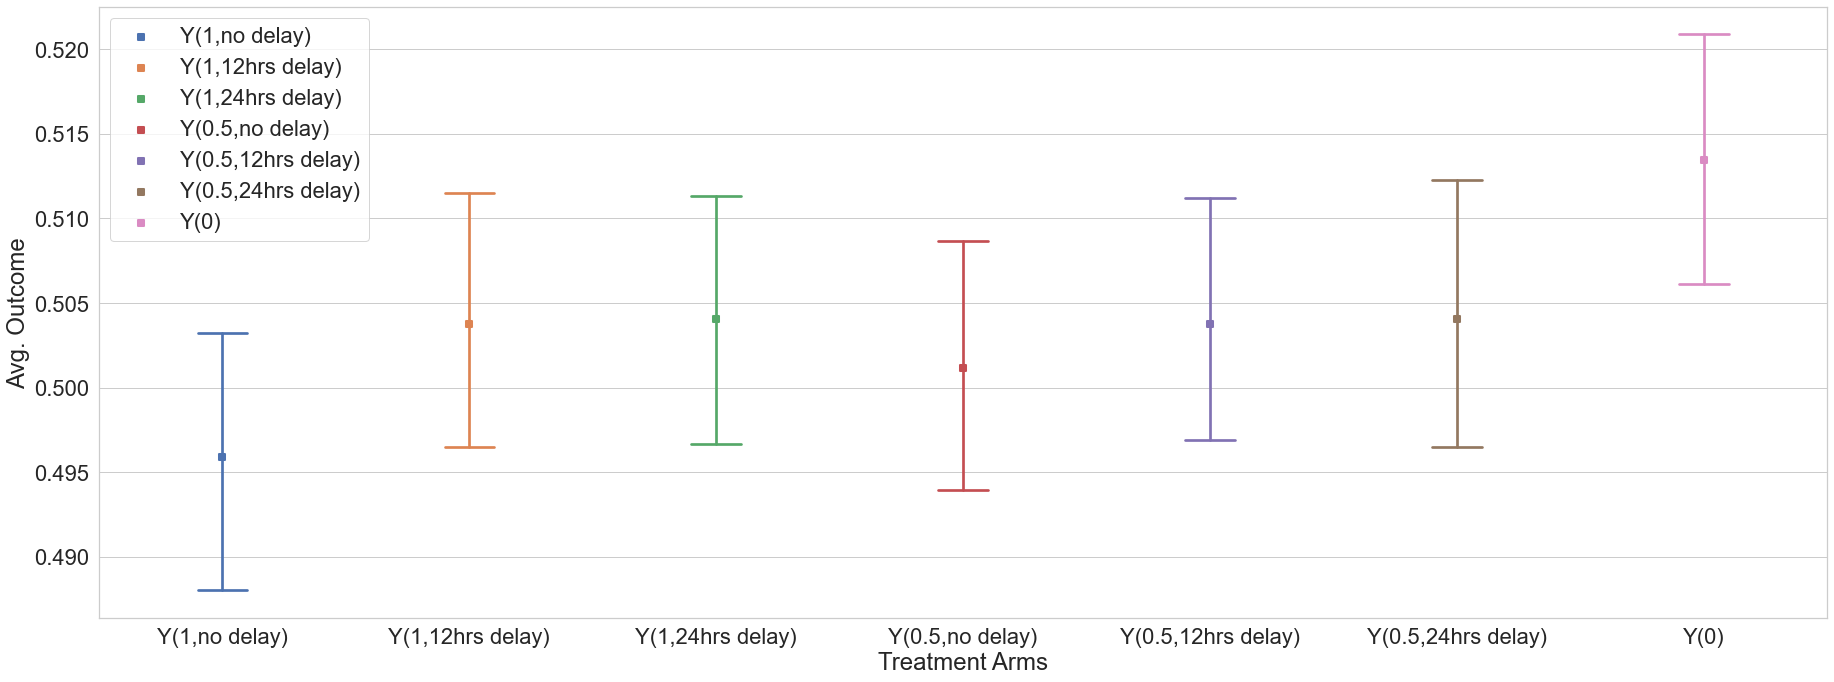

In [45]:
sns.set(style="whitegrid", font_scale=2)
Ys = [col for col in df_Y.columns if "Y" in col]
Emaxs = [col for col in df_Y.columns if r"$E_{max}$" in col]
Etotals = [col for col in df_Y.columns if r"$E_{total}$" in col]
fig, ax = plt.subplots(figsize=(26, 10))
sns.pointplot(
    data=df_Y[Ys].stack().reset_index(),
    x="level_1",
    y=0,
    ax=ax,
    join=False,
    capsize=0.2,
    markers="s",
    hue="level_1",
)
plt.legend()
plt.xlabel("Treatment Arms")
plt.ylabel("Avg. Outcome")
plt.tight_layout()

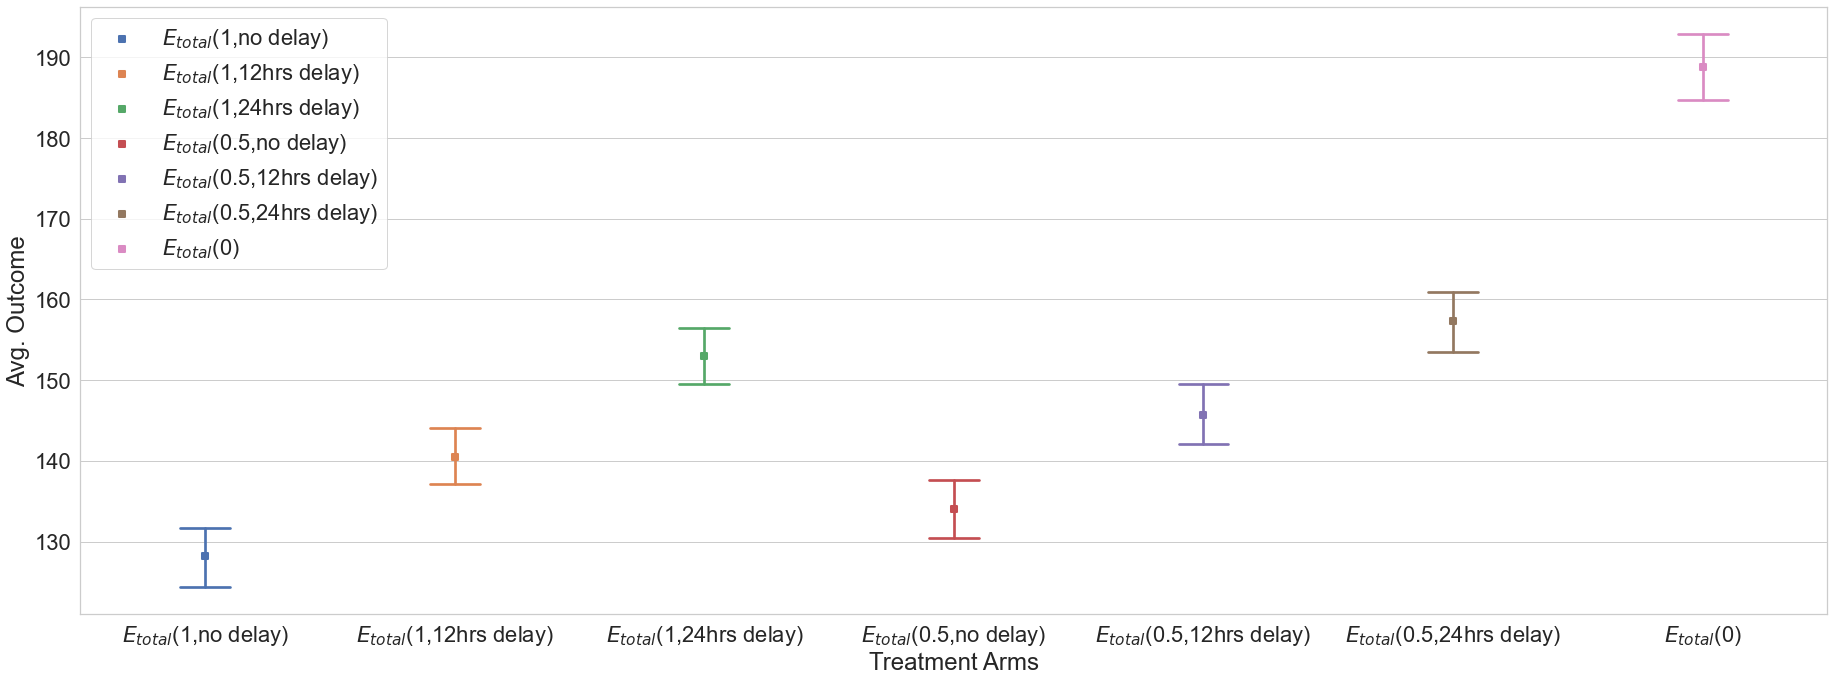

In [46]:
sns.set(style="whitegrid", font_scale=2)
Ys = [col for col in df_Y.columns if "Y" in col]
Emaxs = [col for col in df_Y.columns if r"$E_{max}$" in col]
Etotals = [col for col in df_Y.columns if r"$E_{total}$" in col]
fig, ax = plt.subplots(figsize=(26, 10))
sns.pointplot(
    data=df_Y[Etotals].stack().reset_index(),
    x="level_1",
    y=0,
    ax=ax,
    join=False,
    capsize=0.2,
    markers="s",
    hue="level_1",
)
plt.legend()
plt.xlabel("Treatment Arms")
plt.ylabel("Avg. Outcome")
plt.tight_layout()

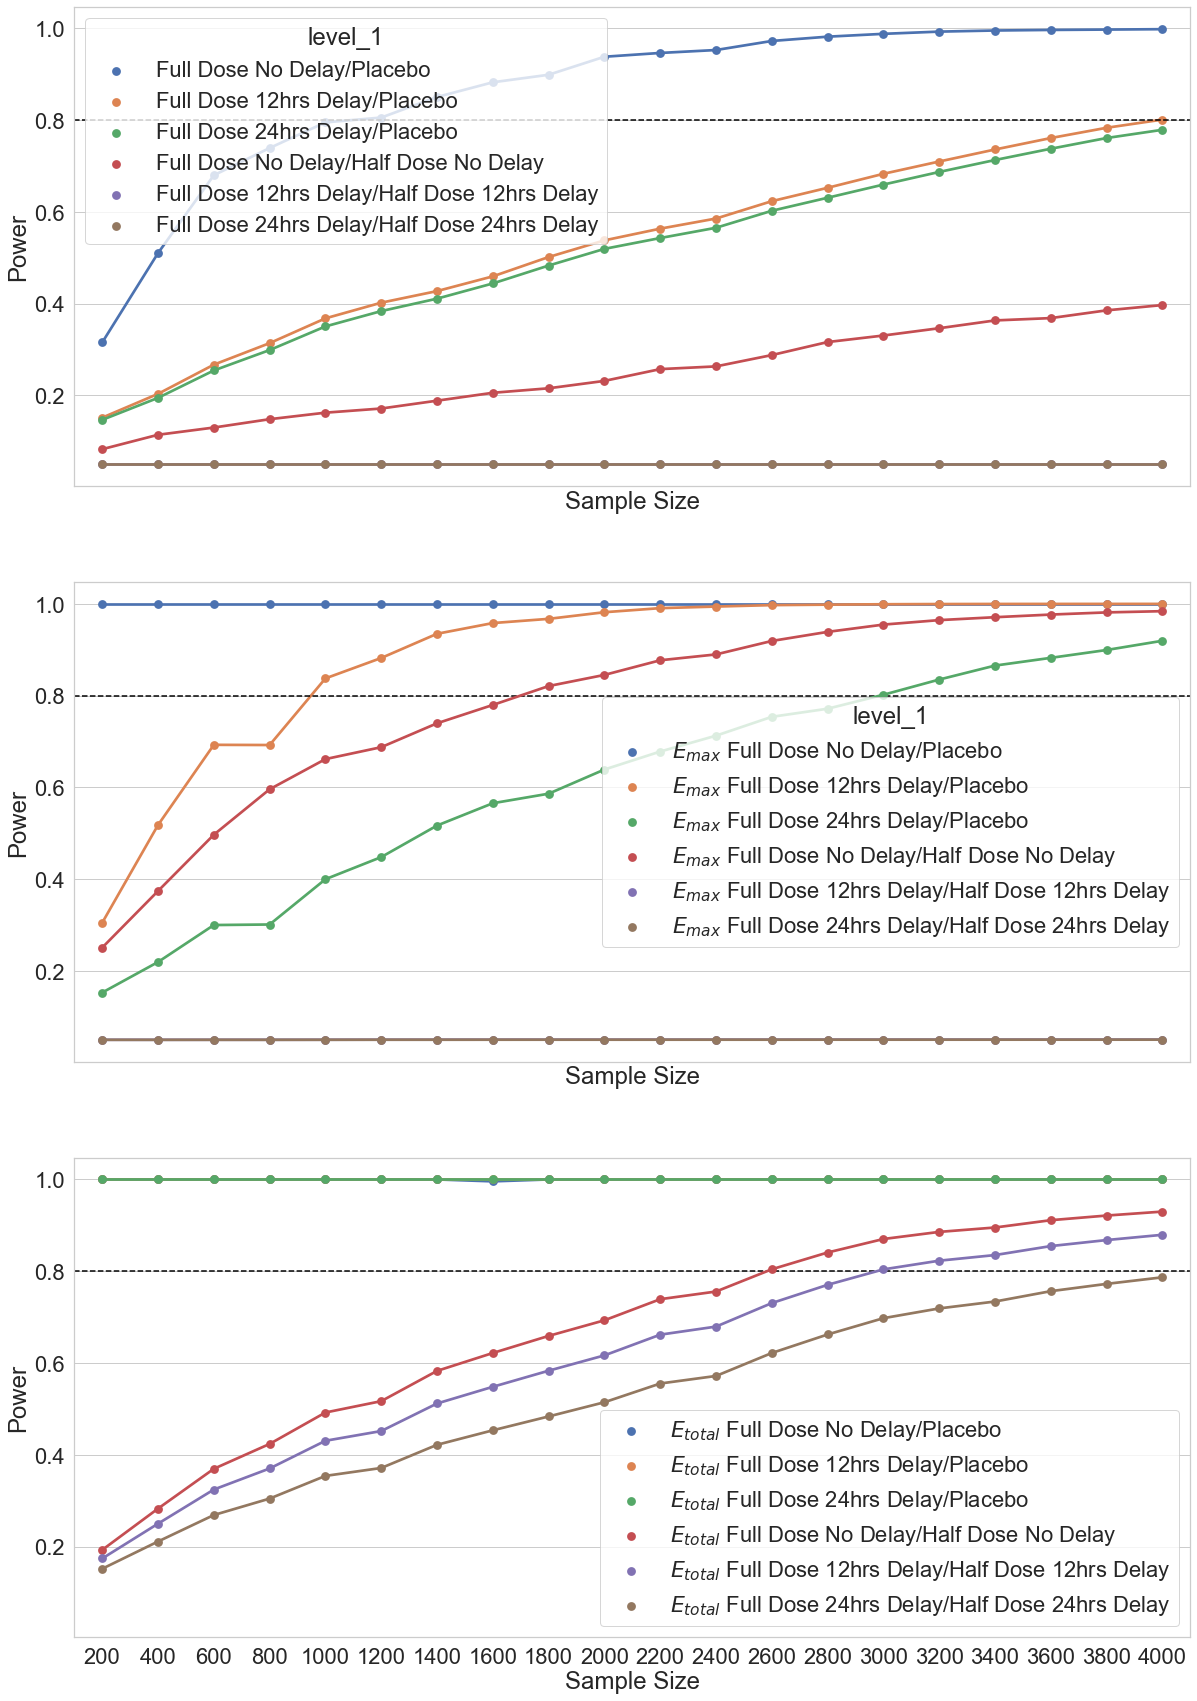

In [47]:
fig, ax = plt.subplots(figsize=(20, 30), nrows=3, sharex=True, sharey=True)
# power_df.plot(ax=ax)
sns.pointplot(
    data=power_df[
        [
            "Full Dose No Delay/Placebo",
            "Full Dose 12hrs Delay/Placebo",
            "Full Dose 24hrs Delay/Placebo",
            "Full Dose No Delay/Half Dose No Delay",
            "Full Dose 12hrs Delay/Half Dose 12hrs Delay",
            "Full Dose 24hrs Delay/Half Dose 24hrs Delay",
        ]
    ]
    .stack()
    .reset_index(),
    hue="level_1",
    x="level_0",
    y=0,
    ax=ax[0],
)
sns.pointplot(
    data=power_df[
        [
            r"$E_{max}$ Full Dose No Delay/Placebo",
            r"$E_{max}$ Full Dose 12hrs Delay/Placebo",
            r"$E_{max}$ Full Dose 24hrs Delay/Placebo",
            r"$E_{max}$ Full Dose No Delay/Half Dose No Delay",
            r"$E_{max}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay",
            r"$E_{max}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay",
        ]
    ]
    .stack()
    .reset_index(),
    hue="level_1",
    x="level_0",
    y=0,
    ax=ax[1],
)
sns.pointplot(
    data=power_df[
        [
            r"$E_{total}$ Full Dose No Delay/Placebo",
            r"$E_{total}$ Full Dose 12hrs Delay/Placebo",
            r"$E_{total}$ Full Dose 24hrs Delay/Placebo",
            r"$E_{total}$ Full Dose No Delay/Half Dose No Delay",
            r"$E_{total}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay",
            r"$E_{total}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay",
        ]
    ]
    .stack()
    .reset_index(),
    hue="level_1",
    x="level_0",
    y=0,
    ax=ax[2],
)
ax[0].axhline(0.8, ls="--", c="black")
ax[1].axhline(0.8, ls="--", c="black")
ax[2].axhline(0.8, ls="--", c="black")

ax[0].set_xlabel("Sample Size")
ax[1].set_xlabel("Sample Size")
ax[2].set_xlabel("Sample Size")

ax[0].set_ylabel("Power")
ax[1].set_ylabel("Power")
ax[2].set_ylabel("Power")

plt.legend()
fig.savefig("/Users/harshparikh/Documents/RCT_sim_code/Power/" + "power2.png")

Text(0, 0.5, 'Power')

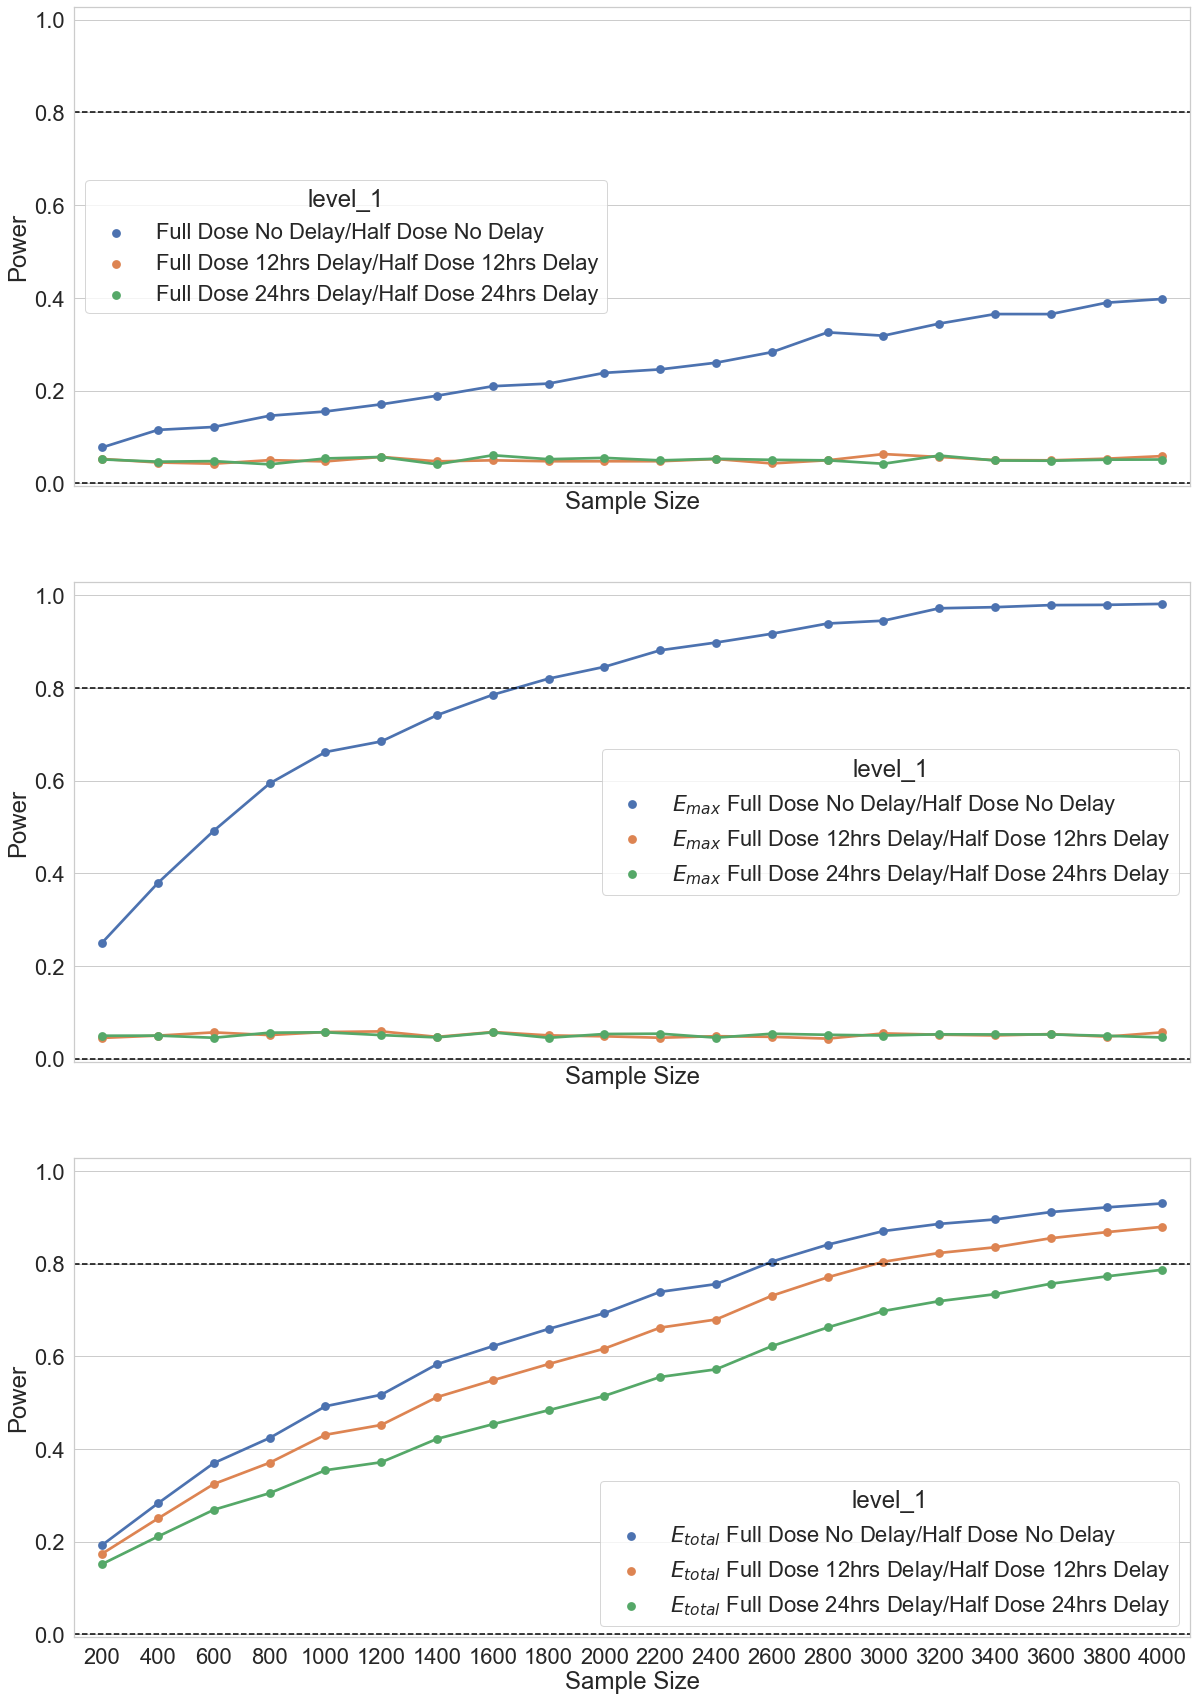

In [48]:
fig, ax = plt.subplots(figsize=(20, 30), nrows=3, sharex=True, sharey=True)
# power_df.plot(ax=ax)
sns.pointplot(
    data=(
        power_df[
            [
                "Full Dose No Delay/Half Dose No Delay",
                r"Full Dose 12hrs Delay/Half Dose 12hrs Delay",
                r"Full Dose 24hrs Delay/Half Dose 24hrs Delay",
            ]
        ]
        + np.random.normal(
            0,
            0.005,
            size=(
                power_df[
                    [
                        "Full Dose No Delay/Half Dose No Delay",
                        r"Full Dose 12hrs Delay/Half Dose 12hrs Delay",
                        r"Full Dose 24hrs Delay/Half Dose 24hrs Delay",
                    ]
                ].shape
            ),
        )
    )
    .stack()
    .reset_index(),
    hue="level_1",
    x="level_0",
    y=0,
    ax=ax[0],
)
sns.pointplot(
    data=(
        power_df[
            [
                r"$E_{max}$ Full Dose No Delay/Half Dose No Delay",
                r"$E_{max}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay",
                r"$E_{max}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay",
            ]
        ]
        + np.random.normal(
            0,
            0.005,
            size=(
                power_df[
                    [
                        "Full Dose No Delay/Half Dose No Delay",
                        r"Full Dose 12hrs Delay/Half Dose 12hrs Delay",
                        r"Full Dose 24hrs Delay/Half Dose 24hrs Delay",
                    ]
                ].shape
            ),
        )
    )
    .stack()
    .reset_index(),
    hue="level_1",
    x="level_0",
    y=0,
    ax=ax[1],
)
sns.pointplot(
    data=power_df[
        [
            r"$E_{total}$ Full Dose No Delay/Half Dose No Delay",
            r"$E_{total}$ Full Dose 12hrs Delay/Half Dose 12hrs Delay",
            r"$E_{total}$ Full Dose 24hrs Delay/Half Dose 24hrs Delay",
        ]
    ]
    .stack()
    .reset_index(),
    hue="level_1",
    x="level_0",
    y=0,
    ax=ax[2],
)
ax[0].axhline(0.8, ls="--", c="black")
ax[1].axhline(0.8, ls="--", c="black")
ax[2].axhline(0.8, ls="--", c="black")
ax[0].axhline(0.0, ls="--", c="black")
ax[1].axhline(0.0, ls="--", c="black")
ax[2].axhline(0.0, ls="--", c="black")

ax[0].set_xlabel("Sample Size")
ax[1].set_xlabel("Sample Size")
ax[2].set_xlabel("Sample Size")

ax[0].set_ylabel("Power")
ax[1].set_ylabel("Power")
ax[2].set_ylabel("Power")

# Study: Effect of Delay in Treatment (same drug)

In [ ]:
halflife = np.array([t_half[k] for k in drugs_interest])
N = pd_param_df.shape[0]
sample_size = 10
batch = 100
power_df = pd.DataFrame()
for seed in range(0,10):
    np.random.seed(seed)
    df_Y = pd.DataFrame()
    for j in tqdm.tqdm(range(sample_size)):
        idxarray = np.random.randint(N,size=batch) # sampling a random unit
        df_Y_ = pd.DataFrame() # local dataframe to store results 
        df_Y_['sid'] = [pd_param_df.index[i] for i in idxarray]

        # simulating unit under no delay
        Y1, Y2, Y3, Y4 = [], [], [], []
        for i in idxarray:
            E2,D2 = sim(pd_param_df.iloc[i],halflife=halflife,dose=1)
            Esum2,Dsum2 = summary(E2,D2)
            C1 = df_coarse_max.drop(columns=['mRS','E']+drugs_interest).iloc[i]
            Y2 += list(outcome(Esum2,Dsum2,C1,model_y=m_y,drugs_interest=drugs_interest))

            # simulating unit under 12hrs delay
            E3,D3 = sim(pd_param_df.iloc[i],halflife=halflife,dose=1,delay=72)
            Esum3,Dsum3 = summary(E3,D3)
            C1 = df_coarse_max.drop(columns=['mRS','E']+drugs_interest).iloc[i]
            Y3 += list(outcome(Esum3,Dsum3,C1,model_y=m_y,drugs_interest=drugs_interest))

             # simulating unit under 18hrs delay
            E4,D4 = sim(pd_param_df.iloc[i],halflife=halflife,dose=1,delay=108)
            Esum4,Dsum4 = summary(E4,D4)
            C1 = df_coarse_max.drop(columns=['mRS','E']+drugs_interest).iloc[i]
            Y4 += list(outcome(Esum4,Dsum4,C1,model_y=m_y,drugs_interest=drugs_interest))

            # simulating unit under no drugs (infinite delay)
            E1,D1 = sim(pd_param_df.iloc[i],halflife=halflife,dose=0)
            Esum1,Dsum1 = summary(E1,D1)
            C1 = df_coarse_max.drop(columns=['mRS','E']+drugs_interest).iloc[i]
            Y1 += list(outcome(Esum1,Dsum1,C1,model_y=m_y,drugs_interest=drugs_interest))


        df_Y_['Y(no delay)'] = Y2
        df_Y_['Y(12hrs delay)'] = Y3
        df_Y_['Y(18hrs delay)'] = Y4
        df_Y_[r'Y($\infty$ delay)'] = Y1




        df_Y_ = df_Y_.set_index('sid')

        df_Y = df_Y.append(df_Y_)

        power_ = pd.DataFrame([[ power(df_Y['Y(no delay)'],df_Y['Y(12hrs delay)']), 
                                power(df_Y['Y(12hrs delay)'],df_Y['Y(18hrs delay)']), 
                                power(df_Y['Y(18hrs delay)'],df_Y[r'Y($\infty$ delay)']),
                                power(df_Y['Y(no delay)'],df_Y[r'Y($\infty$ delay)']) ]],index=[batch*(j+1)],columns=['12hrs delay/no delay',
                                                                                                          '18hrs delay/12hrs delay',
                                                                                                          r'$\infty$ delay/18hrs delay',
                                                                                                          r'$\infty$ delay/no delay'])
        power_df = power_df.append(power_)


# fig = plt.figure(constrained_layout=True,figsize=(10,5))
# gs = fig.add_gridspec(3, 4)

# ax1 = fig.add_subplot(gs[0, :-1])
# ax2 = fig.add_subplot(gs[1, :-1])
# ax3 = fig.add_subplot(gs[2, :-1])
# ax4 = fig.add_subplot(gs[:, -1])

# ax = [ax1,ax2,ax3,ax4]

# plot(E1,D1,Y1,drugs_interest,ax,i=1)
# plot(E2,D2,Y2,drugs_interest,ax,i=2)
# plot(E3,D3,Y3,drugs_interest,ax,i=3)
# plot(E4,D4,Y4,drugs_interest,ax,i=4)

In [ ]:
power_df.stack().reset_index()

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
# power_df.plot(ax=ax)
sns.pointplot(data=power_df.stack().reset_index(),hue='level_1',x='level_0',y=0,errwidth=0)
plt.axhline(0.8,ls='--',c='black')
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.legend()
fig.savefig('/Users/harshparikh/Documents/RCT_sim_code/Power/'+'power.png')

In [ ]:
sns.set(style='whitegrid',font_scale=2)
fig,ax = plt.subplots(figsize=(13,6))
sns.pointplot(data=df_Y.stack().reset_index(),x='level_1',y=0,ax=ax,join=False,capsize=0.2,markers='s',hue='level_1')
plt.legend()
plt.xlabel('Treatment Arms')
plt.ylabel('Avg. Outcome')
plt.tight_layout()
fig.savefig('/Users/harshparikh/Documents/RCT_sim_code/Power/'+'sim_outcome_n1000.png')

In [ ]:
pd_param_df.index[i]

In [ ]:
np.random.power(0.1)

In [ ]:
import scipy.stats as stats


In [ ]:
stats.norm.ppf(0.95)

In [ ]:
stats.norm.cdf(2)

In [ ]:
a = np.zeros((10,))
a[:, = np.array([10 for timepoint in range(0,10,2)])
a